Method for estimating the canopy cover of a 20x20 meters area using LiDAR data. 

Given this 20x20 meters area, the canopy cover is estimated as the percentage of points that are above a certain threshold (in this case 3 meters) inside each point. 

To find the best threshold a grid can be used. It can also be estimated using the average tree height of that zone, from other sources data.

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import time
from GFire_utils.AllFunctions import *

pd.set_option('display.max_columns', None)

In [35]:
# Hyperparameters
x_coord = 'x'
y_coord = 'y'
z_coord = 'z'
lidar_columns = [x_coord, y_coord, z_coord, 'class']
groundtruth_columns = [x_coord, y_coord, 'CC']
heights_columns = [x_coord, y_coord, z_coord]
outliers = 135

gt_inc = 20 # Meters increment of each point of the lidar blocks
height_inc = 2 

gt_centered = True # True if the coordenates of the gt are the center of the block. False if are the bottom-left edge
height_centered = True 

threshold = 3 # Meters from which we start considering that a vegetation is part of the cover

In [36]:
# LiDAR and groundtruth reading
my_block = pd.read_csv('../toy dataset/input_toydataset.txt', sep=' ', header = None, names = lidar_columns)
groundtruth = pd.read_csv('../toy dataset/groundtruth_toydataset.csv', sep=' ', header = None, names = groundtruth_columns)

# Heights reading
metadata = pd.read_csv('../toy dataset/met2v10as0f279122mr1r010.txt', sep=' ', skipinitialspace=True, header = None,
                       skip_blank_lines=True, nrows=6)
NCOLS, NROWS, XCENT, YCENT, CELLSIZE, NODATA_VALUE = map(int, metadata.iloc[:][1])

heights = pd.read_csv('../toy dataset/met2v10as0f279122mr1r010.txt', sep=' ', header = None,
                      skip_blank_lines=True, skiprows=6)

In [37]:
# Fixing formats
heights = fix_format(heights, NCOLS)
heights = index_matrix(heights, XCENT, YCENT, CELLSIZE)
heights.columns = heights_columns

if height_centered: # Situating Coordenates to the bottom left corner of the square
    heights[x_coord] -= height_inc/2
    heights[y_coord] -= height_inc/2
    
if gt_centered:
    groundtruth[x_coord] -= gt_inc/2
    groundtruth[y_coord] -= gt_inc/2
    
# Percentage cannot exceed 100 
aux = groundtruth['CC'].copy()
aux[aux>100] = 100
groundtruth['CC'] = aux

# Dropping outliers
my_block = my_block[my_block['class'] != outliers]

# Matching gt and block
if (my_block[x_coord][0] //gt_inc * gt_inc) % gt_inc != groundtruth[x_coord][0] % gt_inc: 
    # Blocks don't match, ones are even and others are odd
    adj_x = 2*(my_block[x_coord] % gt_inc > gt_inc/2)-1
    adj_y = 2*(my_block[y_coord] % gt_inc > gt_inc/2)-1
else:
    adj_x = 0
    adj_y = 0

In [38]:
# Merging heights and points
my_block['height_merging_x'] = ( my_block[x_coord]// height_inc ) * height_inc
my_block['height_merging_y'] = ( my_block[y_coord]// height_inc ) * height_inc

heights.columns = ['height_merging_x','height_merging_y', 'surface_z']
if (my_block['height_merging_x'][0] //height_inc * height_inc) % height_inc != heights['height_merging_x'][0] % height_inc: 
    # Blocks don't match, ones are even and others are odd
    my_block['height_merging_x'] += height_inc/2 * (2*(my_block['height_merging_x'] % 2 == 1)-1)
    my_block['height_merging_y'] += height_inc/2 * (2*(my_block['height_merging_y'] % 2 == 1)-1)

my_block = pd.merge(my_block, heights, on=['height_merging_x','height_merging_y'], how='left')

if my_block['surface_z'].isnull().sum() != 0:
    print("Height Merging was not made correctly")

In [39]:
# Calculating height
my_block['height'] = my_block[z_coord] - my_block['surface_z']

my_block.drop(['surface_z', 'height_merging_x', 'height_merging_y'], axis=1, inplace=True)

In [40]:
# Grouping points into blocks
my_block['x_p'] = my_block[x_coord]// gt_inc * gt_inc + gt_inc/2 * adj_x
my_block['y_p'] = my_block[y_coord]// gt_inc * gt_inc + gt_inc/2 * adj_y

In [41]:
# # Approach 1: Definim el percentatge de cobertura com al percentatge de punts que es troben per sobre d'un threshold
df_canopy = my_block.query('height > @threshold').copy()

df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
df_canopy = df_canopy.groupby(['x_p','y_p'])[['counted_canopy']].count().reset_index()

my_block['counted_no_canopy'] = np.zeros(my_block.shape[0])
my_block = my_block.groupby(['x_p', 'y_p'])[['counted_no_canopy']].count().reset_index()

my_block = pd.merge(my_block, df_canopy, how='left', on = ['x_p','y_p'])

my_block['counted_canopy'].fillna(0, inplace=True)
my_block['predicted_CC'] = 100*my_block['counted_canopy'] / my_block['counted_no_canopy']

In [42]:
# Merging gt and blocks
groundtruth.columns = ['x_p','y_p','CC']
my_block = pd.merge(my_block, groundtruth, how='inner', on = ['x_p', 'y_p'])

if my_block.shape[0] != groundtruth.shape[0]:
    print("Groundtruth merging done wrong")

In [43]:
# Calculating score
r2 = r2_score(my_block['CC'], my_block['predicted_CC'])

print("R2 score:", r2)

R2 score: 0.7540009571167059


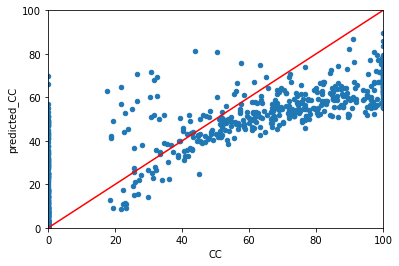

In [44]:
# Plotting the results
my_block.plot.scatter('CC', 'predicted_CC')
plt.xlim(0, 100)
plt.ylim(0,100)
plt.plot([0,100],[0,100], c='r')

plt.show()